# TM10007 Assignment

In [ ]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

## Description of data set
Import data from the ADNI dataset. Find empty values if present. 

In [ ]:
# Import Data
from adni.load_data import load_data
import numpy as np
import pandas as pd

# Import Data
data = load_data()
data_pandas = pd.DataFrame(data)
print(f'Total number of samples: {len(data.index)}')
print(f'Total number of columns: {len(data.columns)}')
print(f'Total amount of features: {len(data.columns)-2}')

# Find empty / NaN entry in pandas dataframe
data_pandas = data_pandas.replace(' ', np.nan) 
empty_values = np.where(pd.isnull(data_pandas))

if ~empty_values[0] == []:
  print(f'Empty values can be found at index {empty_values}')
else:
  print('There are no empty values found.')
  pass

# Percentage AD and CN
number_AD = data_pandas['label'].value_counts()['AD']
number_CN = data_pandas['label'].value_counts()['CN']
print(f"Within the dataset {number_AD} samples are from people with Alzheimer Disease")
print(f"The other {number_CN} samples are from people without Alzheimer Disease") 


Total number of samples: 855
Total number of columns: 268
Total amount of features: 266
There are no empty values found.
Within the dataset 519 samples are from people with Alzheimer Disease
The other 336 samples are from people without Alzheimer Disease


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


# Preprocessing of the data

## Dividing data in a designset (80%) and testset (20%)

In [ ]:
# import modules
from sklearn.model_selection import train_test_split

# Divide data in label and feature set 
labels = data['label']
features = data.drop(columns=['label'])

# Divide data in trainingsset (80%) and testset (20%) stratified for the label
data_designset, data_testset, label_designset, label_testset = train_test_split(features, labels, test_size=.2, random_state=1, stratify=data['label'])

# Check the stratification 
percent_AD_train = (label_designset.value_counts()['AD'])/len(label_designset)*100
percent_CN_train = (label_designset.value_counts()['CN'])/len(label_designset)*100
percent_AD_test = (label_testset.value_counts()['AD'])/len(label_testset)*100
percent_CN_test = (label_testset.value_counts()['CN'])/len(label_testset)*100

print(f"{percent_AD_train:.2f}% of the train data are Alzheimer disease samples.")
print(f"{percent_CN_train:.2f}% of the train data are control samples.")
print(f"{percent_AD_test:.2f}% of the test data are Alzheimer disease samples.")
print(f"{percent_CN_test:.2f}% of the test data are control samples.")


60.67% of the train data are Alzheimer disease samples.
39.33% of the train data are control samples.
60.82% of the test data are Alzheimer disease samples.
39.18% of the test data are control samples.


## Feature Dropping

Find columns where > 90% of the column has value zero. Remove the features if this is true. Besides, remove features if the whole column has one unique value. 

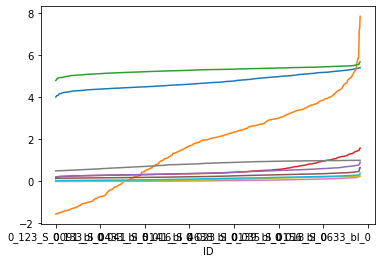

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

data_designset = data_designset.drop(columns=data_designset.columns[data_designset.eq(0).mean()>0.9])
data_designset = data_designset[data_designset.columns[data_designset.nunique() > 1]]
data_designset_feature_names = data_designset.columns

scaling_check = data_designset['hf_entropy'].sort_values()
scaling_check.plot()
scaling_check_2 = data_designset['hf_kurtosis'].sort_values()
scaling_check_2.plot()
scaling_check_3 = data_designset['tf_LBP_std_R3_P12'].sort_values()
scaling_check_3.plot()
scaling_check_4 = data_designset['hf_quartile_range'].sort_values()
scaling_check_4.plot()
scaling_check_5 = data_designset['hf_std'].sort_values()
scaling_check_5.plot()
scaling_check_6 = data_designset['tf_GLRLM_ShortRunEmphasis'].sort_values()
scaling_check_6.plot()
scaling_check_7 = data_designset['tf_NGTDM_Complexity'].sort_values()
scaling_check_7.plot()
scaling_check_8 = data_designset['tf_GLRLM_GrayLevelNonUniformityNormalized'].sort_values()
scaling_check_8.plot()
scaling_check_9 = data_designset['tf_GLRLM_GrayLevelVariance'].sort_values()
scaling_check_9.plot()
scaling_check_10 = data_designset['tf_GLRLM_ShortRunLowGrayLevelEmphasis'].sort_values()
scaling_check_10.plot()

# Eventueel verwijderen als meer dan 90% hetzelfde is. 
# Toevoegen welke kolom die verwijdert.

## Scaling

In [ ]:
# Different methods for feature scaling. Decision will be made after usage of PCA
# Import modules
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# # Robust scaler - based on percentiles. Not influenced by a few number of very large marginal outliers
# trans = RobustScaler()
# x_train_robust = trans.fit_transform(x_train)

# # Standard scaler - removes the mean and scales the data to unit variance
# scaler = StandardScaler()
# x_train_scaler = scaler.fit_transform(x_train)

# MinMax scaler - rescales data set such that all feature values are in range [0,1]
norm = MinMaxScaler().fit(data_designset)
data_designset_norm = norm.transform(data_designset)
data_designset_norm = pd.DataFrame(data_designset_norm)
data_designset_norm.columns = data_designset_feature_names


# Cross validation
First a stratified k fold cross validation is used with 10 splits. 
Feature selection - best method to select features from this multi feature space. The options looked in to are:
1. Univariate
2. Univariate + PCA
3. PCA

Classifier - best classifier with the remaining features. Three classifiers are looked in to based on literature review.
1. K-NN (normalized scaler)
2. SVM 
3. CNN

# Univariate optimalisatie beide

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import neighbors, metrics
import seaborn
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import math
from tabulate import tabulate

# configure the cross-validation procedure. A 10 fold split is used stratified for the label. 
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)
k_list = list(range(1, 50, 2))

threshold = []
mean_auc_val = []
std_auc_val = []
optimal_k = []

thresholds = np.linspace(0,1,11)
for threshold_feature_relative in thresholds:
  all_train = []
  all_val = []
  results = []
  best_n_neighbors = []


  for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
    x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
    y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

    train_scores = []
    val_scores = []

    # Feature selection using univariate statistical testing. An one-way ANOVA is used and the features are scored. 
    bestfeatures = SelectKBest(score_func=f_classif, k=len(data_designset_norm.columns))
    fit = bestfeatures.fit(x_train, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(data_designset_norm.columns)


    feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
    feature_scores.columns = ['Specs','Score']  
    feature_scores = feature_scores.sort_values('Score')
    highest_feature_score = feature_scores['Score'].iloc[-1]
    # threshold_feature_relative = 0.5                                                 # Optimization of parameter is needed
    threshold_feature_score = threshold_feature_relative*highest_feature_score

    # Every feature scoring above the threshold will be selected. 
    feature_selection_names = []
    for i in range(0,len(feature_scores['Score'])):
      if feature_scores['Score'].iloc[i]>=threshold_feature_score:
        feature_selection_names.append(feature_scores['Specs'].iloc[i])

    selected_data_univ_designset_norm = data_designset_norm[feature_selection_names]
    selected_data_univ_trainset_norm = selected_data_univ_designset_norm.to_numpy()[train_idx]
    selected_data_univ_valset_norm = selected_data_univ_designset_norm.to_numpy()[val_idx]
    
    # Aplly K-Nearest Neighbor classifier to features selected with univariate
    for k in k_list: 
      clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
      clf_knn.fit(selected_data_univ_trainset_norm, y_train)

      # Test the classifier on the selected features from the training data and plot 
      train_proba = clf_knn.predict_proba(selected_data_univ_trainset_norm)[:,1]
      val_proba = clf_knn.predict_proba(selected_data_univ_valset_norm)[:,1]

      score_train = metrics.roc_auc_score(y_train, train_proba)
      score_val = metrics.roc_auc_score(y_val, val_proba)

      train_scores.append(score_train)
      val_scores.append(score_val)

    all_train.append(train_scores)
    all_val.append(val_scores)

    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(1, 26, 2))}
    knn = neighbors.KNeighborsClassifier()
    cv_10fold = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(selected_data_univ_trainset_norm, y_train)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(selected_data_univ_valset_norm)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_val, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
    print(auc)
    
    # Test the classifier on the validation data
    probabilities_train = clf.predict_proba(selected_data_univ_trainset_norm)
    scores_train = probabilities_train[:, 1]
    
    # Get the auc
    auc_train = metrics.roc_auc_score(y_train, scores_train)
    results.append({
        'auc': auc_train,
        'k': clf.n_neighbors,
        'set': 'train'
    })
    
  # Calculate the mean and std
  all_train = np.array(all_train)
  all_val = np.array(all_val)

  train_scores_mean = all_train.mean(axis=0)
  val_scores_mean = all_val.mean(axis=0)

  train_scores_std = all_train.std(axis=0)
  val_scores_std = all_val.std(axis=0)

  # Plot the mean scores and the std as shading
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111)
  ax.grid()
  ax.fill_between(k_list, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
  ax.fill_between(k_list, val_scores_mean - val_scores_std,
                      val_scores_mean + val_scores_std, alpha=0.1,
                      color="g")
  ax.plot(k_list, train_scores_mean, 'o-', color="r",
          label="Training score")
  ax.plot(k_list, val_scores_mean, 'o-', color="g",
          label="Validation score")
  
  # Create results dataframe and plot it
  plt.figure()
  results = pd.DataFrame(results)
  seaborn.boxplot(y='auc', x='set', data=results)

  auc_val = results[results['set'].str.contains('validation')]
  threshold.append(threshold_feature_relative)
  mean_auc_val.append(auc_val['auc'].mean())
  std_auc_val.append(auc_val['auc'].std())
  optimal_k.append(int(np.median(best_n_neighbors)))

  optimal_n = int(np.median(best_n_neighbors))
  print(f"The optimal N={optimal_n}")

auc_table = {'Threshold': threshold, 'Mean AUC': mean_auc_val, 'Standard deviation AUC': std_auc_val, 'Optimal k': optimal_k}
print(tabulate(auc_table, headers='keys', tablefmt='fancy_grid'))


# Univariate waar we al optimale threshold van 0.5

Best classifier: k=21
Best classifier: k=19
Best classifier: k=21
Best classifier: k=19
Best classifier: k=23
Best classifier: k=23
Best classifier: k=21
Best classifier: k=23
Best classifier: k=23
Best classifier: k=19
The optimal N=21


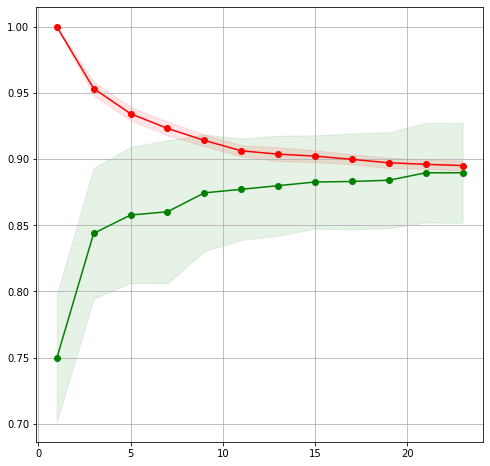

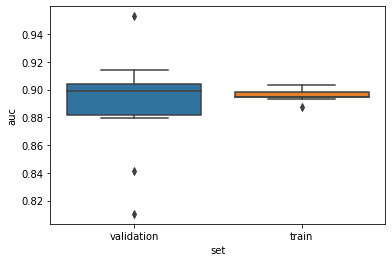

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import neighbors, metrics
import seaborn
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import math

# configure the cross-validation procedure. A 10 fold split is used stratified for the label. 
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)
k_list = list(range(1, 25, 2))

all_train = []
all_val = []
results = []
best_n_neighbors = []

for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
  x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
  y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

  train_scores = []
  val_scores = []

  # Feature selection using univariate statistical testing. An one-way ANOVA is used and the features are scored. 
  bestfeatures = SelectKBest(score_func=f_classif, k=len(data_designset_norm.columns))
  fit = bestfeatures.fit(x_train, y_train)
  dfscores = pd.DataFrame(fit.scores_)
  dfcolumns = pd.DataFrame(data_designset_norm.columns)

  # A threshold is set on 0.5 times the maximum scoring feature.
  feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
  feature_scores.columns = ['Specs','Score']  
  feature_scores = feature_scores.sort_values('Score')
  highest_feature_score = feature_scores['Score'].iloc[-1]
  threshold_feature_relative = 0.5                                                 # Optimization of parameter is needed
  threshold_feature_score = threshold_feature_relative*highest_feature_score

  # Every feature scoring above the threshold will be selected. 
  feature_selection_names = []
  for i in range(0,len(feature_scores['Score'])):
    if feature_scores['Score'].iloc[i]>=threshold_feature_score:
      feature_selection_names.append(feature_scores['Specs'].iloc[i])

  selected_data_designset_norm = data_designset_norm[feature_selection_names]
  selected_data_trainset_norm = selected_data_designset_norm.to_numpy()[train_idx]
  selected_data_valset_norm = selected_data_designset_norm.to_numpy()[val_idx]
  
  for k in k_list: 
    clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    clf_knn.fit(selected_data_trainset_norm, y_train)

    # Test the classifier on the selected features from the training data and plot 
    train_proba = clf_knn.predict_proba(selected_data_trainset_norm)[:,1]
    val_proba = clf_knn.predict_proba(selected_data_valset_norm)[:,1]

    score_train = metrics.roc_auc_score(y_train, train_proba)
    score_val = metrics.roc_auc_score(y_val, val_proba)

    train_scores.append(score_train)
    val_scores.append(score_val)

  all_train.append(train_scores)
  all_val.append(val_scores)

  # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
  # Same as above
  parameters = {"n_neighbors": list(range(1, 26, 2))}
  knn = neighbors.KNeighborsClassifier()
  cv_10fold = StratifiedKFold(n_splits=10)
  grid_search = GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
  grid_search.fit(selected_data_trainset_norm, y_train)
  
  # Get resulting classifier
  clf = grid_search.best_estimator_
  print(f'Best classifier: k={clf.n_neighbors}')
  best_n_neighbors.append(clf.n_neighbors)
  
  # Test the classifier on the test data
  probabilities = clf.predict_proba(selected_data_valset_norm)
  scores = probabilities[:, 1]
  
  # Get the auc
  auc = metrics.roc_auc_score(y_val, scores)
  results.append({
      'auc': auc,
      'k': clf.n_neighbors,
      'set': 'validation'
  })
  
  # Test the classifier on the validation data
  probabilities_train = clf.predict_proba(selected_data_trainset_norm)
  scores_train = probabilities_train[:, 1]
  
  # Get the auc
  auc_train = metrics.roc_auc_score(y_train, scores_train)
  results.append({
      'auc': auc_train,
      'k': clf.n_neighbors,
      'set': 'train'
  })

# Calculate the mean and std of the accuracy
all_train = np.array(all_train)
all_val = np.array(all_val)

train_scores_mean = all_train.mean(axis=0)
val_scores_mean = all_val.mean(axis=0)

train_scores_std = all_train.std(axis=0)
val_scores_std = all_val.std(axis=0)

# Plot the mean scores and the std as shading
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
ax.fill_between(k_list, val_scores_mean - val_scores_std,
                    val_scores_mean + val_scores_std, alpha=0.1,
                    color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, val_scores_mean, 'o-', color="g",
        label="Validation score")

# Create results dataframe and plot it
plt.figure()
results = pd.DataFrame(results)
seaborn.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")
  

### Univariate Feature Selection - BASIS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


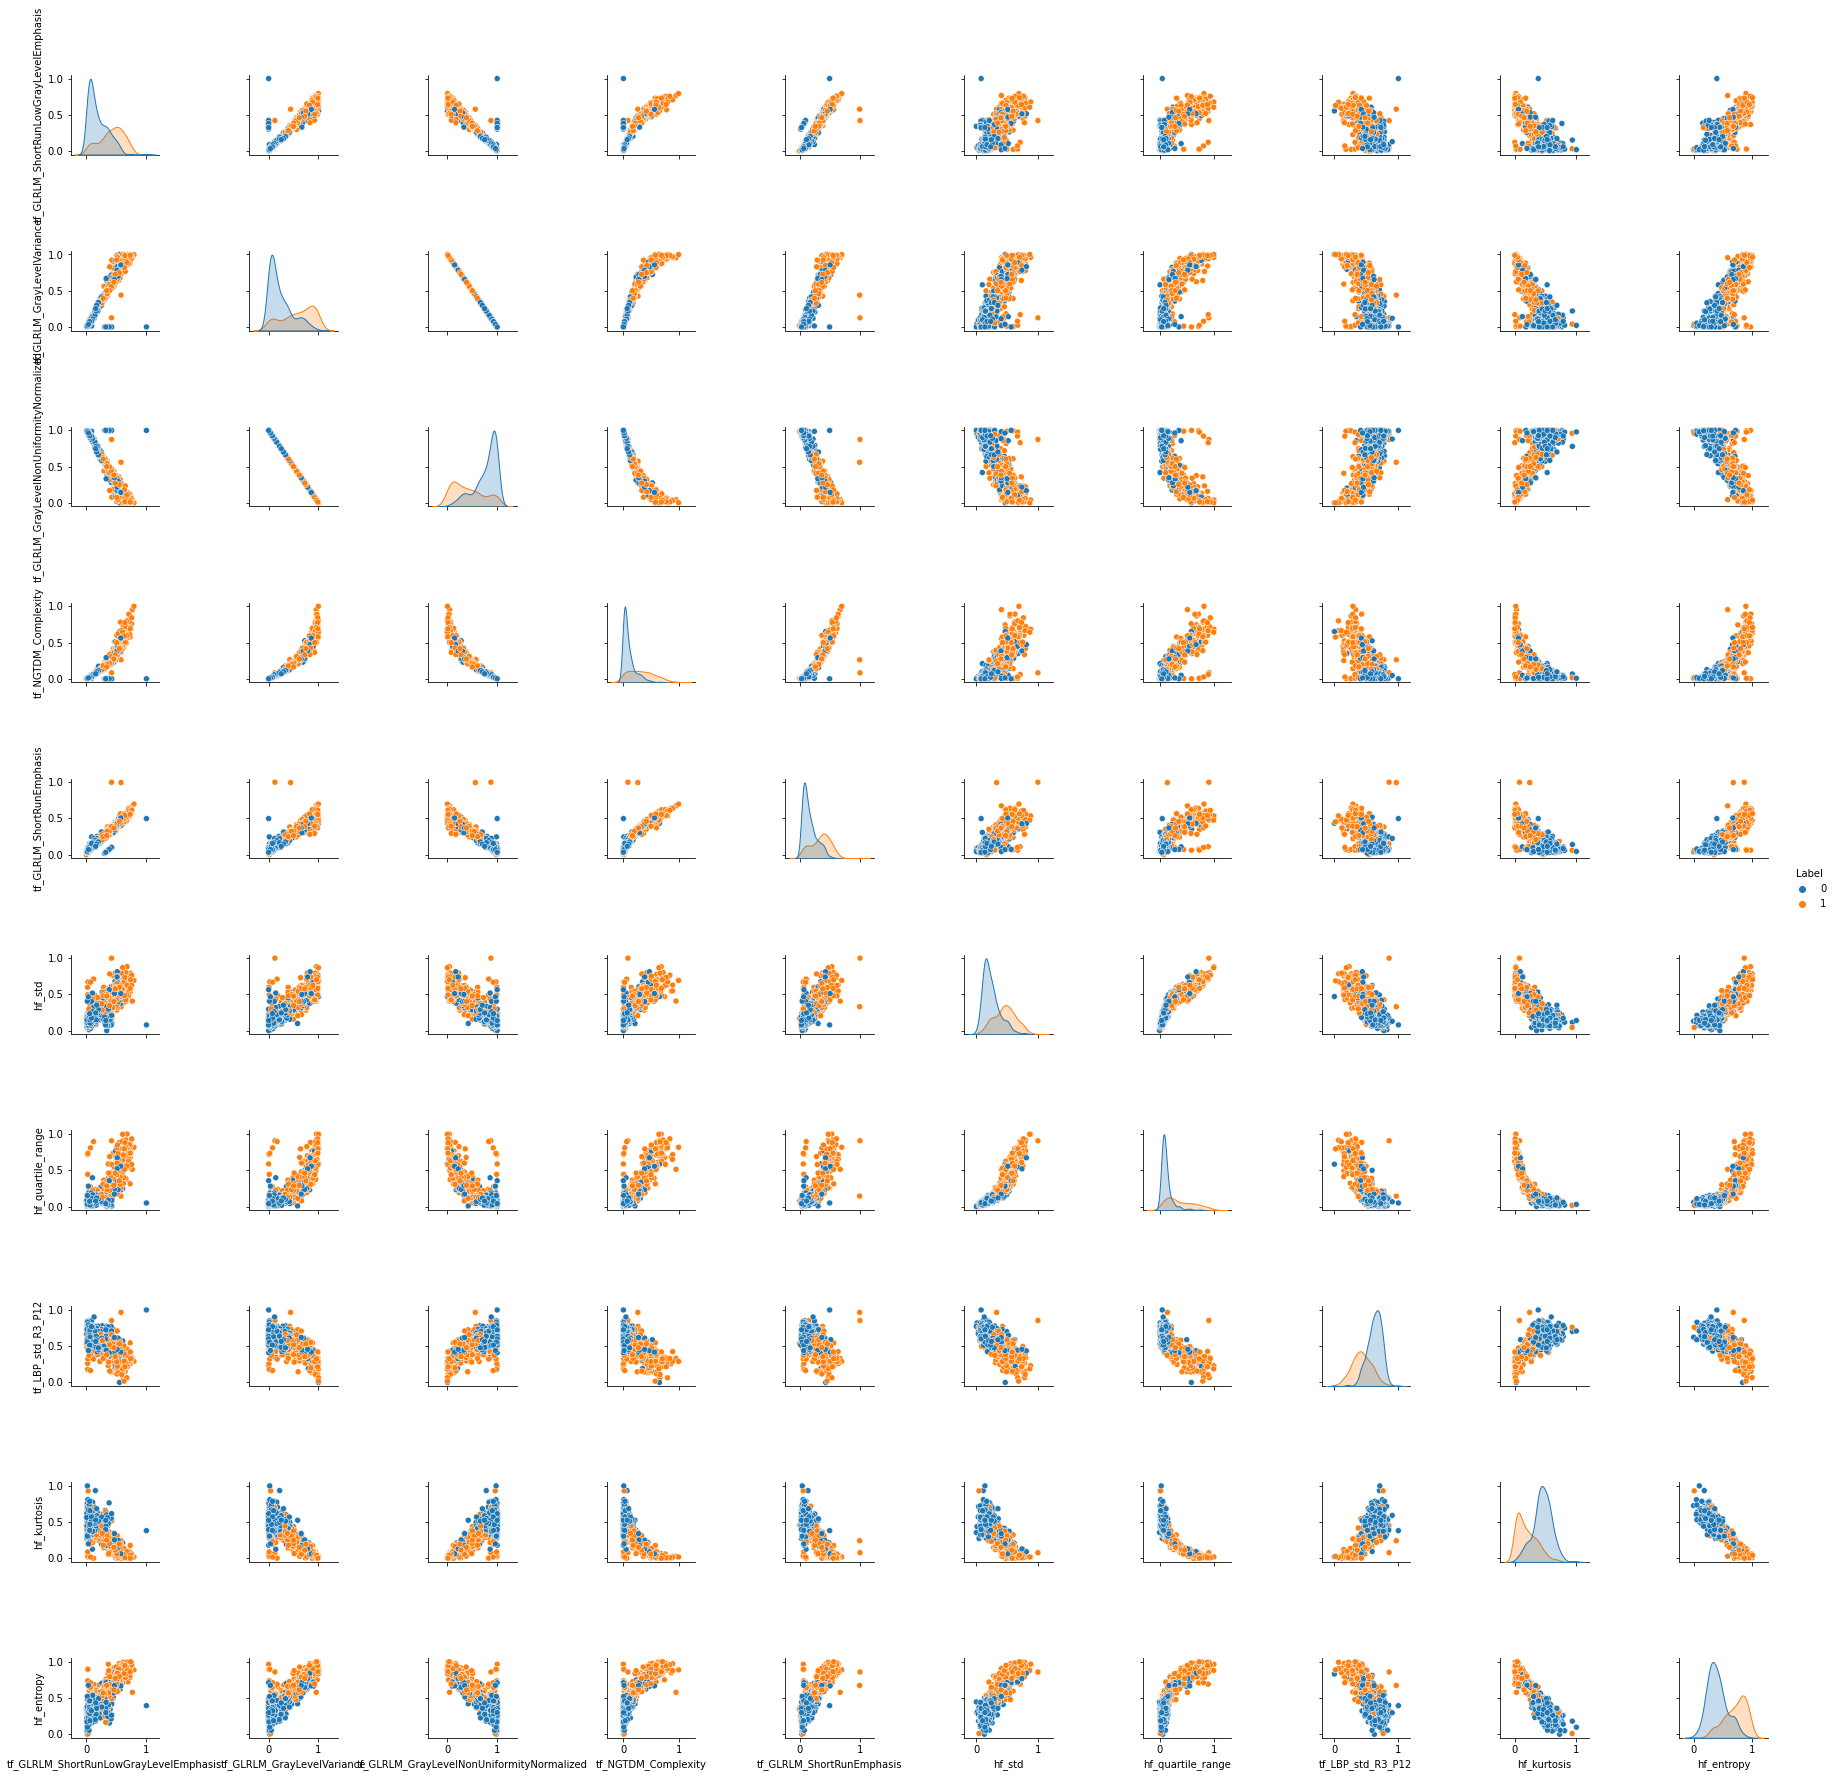

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import math 

bestfeatures = SelectKBest(score_func=f_classif, k=len(data_designset_norm.columns))
fit = bestfeatures.fit(data_designset_norm, label_designset)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(data_designset_norm.columns)

feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
feature_scores.columns = ['Specs','Score']  
feature_scores = feature_scores.sort_values('Score')
highest_feature_score = feature_scores['Score'].iloc[-1]
threshold_feature_relative = 0.5                                                # Optimization of parameter is needed
threshold_feature_score = threshold_feature_relative*highest_feature_score
criteria = feature_scores['Score']>=threshold_feature_score

feature_selection_names = []
for i in range(0,len(feature_scores['Score'])):
  if feature_scores['Score'].iloc[i]>=threshold_feature_score:
    feature_selection_names.append(feature_scores['Specs'].iloc[i])

# print(feature_selection_names)
# print(len(feature_selection_names))
selected_data_designset_norm = data_designset_norm[feature_selection_names]

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(label_designset)
# print(selected_data_designset_norm)
import seaborn as sns
selected_data_designset_norm['Label'] = labels
sns.pairplot(selected_data_designset_norm, hue='Label')

# print(feature_scores.nlargest(10,'Score'))


# PCA - BASIS

In [ ]:
# General Import
from sklearn.decomposition import PCA

# Create a PCA which retains n principle components
n_pca = 5
pca = PCA(n_components=n_pca)

# Fit the PCA model, point_data_train should be a 2D numpy array
# which has one row per subject and the pointdata as columns where
# the columns are x1, y1, z1, x2, y2, z2, ..., xn, yn, zn
pca.fit(x_train)

# Transform data
selected_data_trainset_trans = pca.transform(x_train)
print(data_trainset_trans)

[[-0.4240283   0.69619987  0.75375089 -0.13412269 -0.88390469]
 [-0.88516757 -0.6048795  -0.43968825  0.23650873 -0.13161926]
 [-1.32839282 -1.18676818 -0.71593989  0.37403718 -0.19717475]
 ...
 [-0.87393793  2.06784419  0.20802999  1.72922291  0.23744782]
 [-0.70226101  1.11946552  1.42546138 -0.81896458 -0.35024505]
 [-0.54073193 -0.02707676  0.06449632 -0.34814736  0.22938564]]


## PCA with KNN

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import neighbors, metrics
import seaborn
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import math
from sklearn.decomposition import PCA
!pip install tabulate
from tabulate import tabulate

# configure the cross-validation procedure. A 10 fold split is used stratified for the label. 
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)
k_list = list(range(1, 50, 2))
threshold = []
mean_auc_val = []
std_auc_val = []
optimal_k = []
n_pca = list(range(1,100,4))

for n_component in n_pca:
  
  all_train = []
  all_val = []
  results = []
  best_n_neighbors = []

  for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
    x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
    y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

    train_scores = []
    val_scores = []

    # Create a PCA which retains n principle components
    pca = PCA(n_components=n_component)

    # Fit the PCA model, point_data_train should be a 2D numpy array
    # which has one row per subject and the pointdata as columns where
    # the columns are x1, y1, z1, x2, y2, z2, ..., xn, yn, zn
    pca.fit(x_train)

    # Transform data and create the components of the data 
    selected_data_pca_trainset = pca.transform(x_train)
    selected_data_pca_valset = pca.transform(x_val)

    # Aplly K-Nearest Neighbor classifier to components generated with PCA 
    for k in k_list: 
      clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
      clf_knn.fit(selected_data_pca_trainset, y_train)

      # Test the classifier on the selected features from the training data and plot 
      train_proba = clf_knn.predict_proba(selected_data_pca_trainset)[:,1]
      val_proba = clf_knn.predict_proba(selected_data_pca_valset)[:,1]

      score_train = metrics.roc_auc_score(y_train, train_proba)
      score_val = metrics.roc_auc_score(y_val, val_proba)

      train_scores.append(score_train)
      val_scores.append(score_val)

    all_train.append(train_scores)
    all_val.append(val_scores)

    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(1, 26, 2))}
    knn = neighbors.KNeighborsClassifier()
    cv_10fold = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(selected_data_pca_trainset, y_train)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(selected_data_pca_valset)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_val, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
     
    # Test the classifier on the validation data
    probabilities_train = clf.predict_proba(selected_data_pca_trainset)
    scores_train = probabilities_train[:, 1]
    
    # Get the auc
    auc_train = metrics.roc_auc_score(y_train, scores_train)
    results.append({
        'auc': auc_train,
        'k': clf.n_neighbors,
        'set': 'train'
    })
    
  # Calculate the mean and std
  all_train = np.array(all_train)
  all_val = np.array(all_val)

  train_scores_mean = all_train.mean(axis=0)
  val_scores_mean = all_val.mean(axis=0)

  train_scores_std = all_train.std(axis=0)
  val_scores_std = all_val.std(axis=0)

  # Plot the mean scores and the std as shading
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111)
  ax.grid()
  ax.fill_between(k_list, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
  ax.fill_between(k_list, val_scores_mean - val_scores_std,
                      val_scores_mean + val_scores_std, alpha=0.1,
                      color="g")
  ax.plot(k_list, train_scores_mean, 'o-', color="r",
          label="Training score")
  ax.plot(k_list, val_scores_mean, 'o-', color="g",
          label="Validation score")
  
  # Create results dataframe and plot it
  plt.figure()
  results = pd.DataFrame(results)
  seaborn.boxplot(y='auc', x='set', data=results)

  optimal_n = int(np.median(best_n_neighbors))
  print(f"The optimal N={optimal_n}")

  auc_val = results[results['set'].str.contains('validation')]
  
  threshold.append(n_component)
  mean_auc_val.append(auc_val['auc'].mean())
  std_auc_val.append(auc_val['auc'].std())
  optimal_k.append(int(np.median(best_n_neighbors)))
    
auc_table = {'Number of Components': threshold, 'Mean AUC': mean_auc_val, 'Standard deviation AUC': std_auc_val, 'Optimal k': optimal_k}
print(tabulate(auc_table, headers='keys', tablefmt='fancy_grid'))

# Best values are n_components 21 and 20 k-NN

# SVM Linear + univariate

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn import neighbors, metrics
from sklearn.svm import SVC
import seaborn
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import math
import seaborn as sns
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

# Which kernels do we use:
kernels = ('Polynomial 2', 'Polynomial 3', 'Polynomial 4', 'Polynomial 5', 'Polynomial 6', 'Polynomial 7', 'Polynomial 8', 'Polynomial 9', 'Polynomial 10', 'RBF', 'Sigmoid','Linear')#A function which returns the corresponding SVC model
def getClassifier(ktype): 
  if ktype == 0:
      # Polynomial kernal
      return SVC(kernel='poly', degree=2, gamma="auto", probability=True, random_state=0)
  elif ktype == 1:
      # Polynomial kernal
      return SVC(kernel='poly', degree=3, gamma="auto", probability=True, random_state=0)
  elif ktype == 2:
      # Polynomial kernal
      return SVC(kernel='poly', degree=4, gamma="auto", probability=True, random_state=0)
  elif ktype == 3:
      # Polynomial kernal
      return SVC(kernel='poly', degree=5, gamma="auto", probability=True, random_state=0)
  elif ktype == 4:
      # Polynomial kernal
      return SVC(kernel='poly', degree=6, gamma="auto", probability=True, random_state=0)
  elif ktype == 5:
      # Polynomial kernal
      return SVC(kernel='poly', degree=7, gamma="auto", probability=True, random_state=0)
  elif ktype == 6:
      # Polynomial kernal
      return SVC(kernel='poly', degree=8, gamma="auto", probability=True, random_state=0)
  elif ktype == 7:
      # Polynomial kernal
      return SVC(kernel='poly', degree=9, gamma="auto", probability=True, random_state=0)
  elif ktype == 8:
      # Polynomial kernal
      return SVC(kernel='poly', degree=10, gamma="auto", probability=True, random_state=0)
  elif ktype == 9:
      # Radial Basis Function kernal
      return SVC(kernel='rbf', gamma=0.01, C=1000, probability=True, random_state=0)
  elif ktype == 10:
      # Sigmoid kernal
      return SVC(kernel='sigmoid', gamma="auto", probability=True, random_state=0)
  elif ktype == 11:
      # Linear kernal
      return SVC(kernel='linear', gamma="auto", probability=True, random_state=0)

# Apply SVC and calculate the accuracy and AUC
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)
all_train_mean = []
all_val_mean = []
all_train_std = []
all_val_std = []
all_mean_accuracies = []
all_mean_sensitivities = []
all_mean_specificities = []

for ker in range(12):
  train_scores = []
  val_scores = []
  ACCURACIES = []
  SPECIFICITIES = []
  SENSITIVITIES = []

  for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
    
    x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
    y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

    # Feature selection using univariate statistical testing. An one-way ANOVA is used and the features are scored. 
    bestfeatures = SelectKBest(score_func=f_classif, k=len(data_designset_norm.columns))
    fit = bestfeatures.fit(x_train, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(data_designset_norm.columns)

    feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
    feature_scores.columns = ['Specs','Score']  
    feature_scores = feature_scores.sort_values('Score')
    highest_feature_score = feature_scores['Score'].iloc[-1]
    threshold_feature_relative = 0.7
    threshold_feature_score = threshold_feature_relative*highest_feature_score

    # Every feature scoring above the threshold will be selected. 
    feature_selection_names = []
    for i in range(0,len(feature_scores['Score'])):
      if feature_scores['Score'].iloc[i]>=threshold_feature_score:
        feature_selection_names.append(feature_scores['Specs'].iloc[i])
    
    selected_data_univ_designset_norm = data_designset_norm[feature_selection_names]
    selected_data_univ_trainset_norm = selected_data_univ_designset_norm.to_numpy()[train_idx]
    selected_data_univ_valset_norm = selected_data_univ_designset_norm.to_numpy()[val_idx]

    svclassifier = getClassifier(ker) 
    svclassifier.fit(selected_data_univ_trainset_norm, y_train)   # Train classifier 

    y_pred_train = svclassifier.predict(selected_data_univ_trainset_norm) # Apply classifier on trainset (Make prediction, label with class)
    y_pred_val = svclassifier.predict(selected_data_univ_valset_norm) # Apply classifier on validationset (Make prediction, label with class)
    y_pred_train_score = svclassifier.predict_proba(selected_data_univ_trainset_norm)[:,1] # Apply classifier on trainset (Make prediction, prediction for CN)
    y_pred_train_score = np.round(y_pred_train_score)
    y_pred_val_score = svclassifier.predict_proba(selected_data_univ_valset_norm)[:,1] # Apply classifier on trainset (Make prediction, prediction for CN)
    y_pred_val_score = np.round(y_pred_val_score)
    # print(y_pred_val)         Kunnen verschillen door zie https://scikit-learn.org/stable/modules/svm.html#scores-probabilities 1.4.1.2
    # print(y_pred_val_score)
    score_train = metrics.roc_auc_score(y_train, y_pred_train_score)
    score_val = metrics.roc_auc_score(y_val, y_pred_val_score)
    train_scores.append(score_train)
    val_scores.append(score_val)

    classification_report_val = classification_report(y_val,y_pred_val, output_dict=True)
    accuracy = classification_report_val['accuracy']
    sensitivity = classification_report_val['AD']['recall'] # In binary classification, recall of the positive class is also known as 'sensitivity'
    specificity = classification_report_val['CN']['recall'] # In binary classification, recall of the negative class is also known as 'specificity'

    ACCURACIES.append(accuracy)
    SENSITIVITIES.append(sensitivity)
    SPECIFICITIES.append(specificity)

    # true_positive, false_negative, false_positive, true_negative = metrics.confusion_matrix(y_val,y_pred_val,labels=['AD', 'CN']).ravel()
    # accuracy = metrics.accuracy_score(y_val, y_pred_val)
    # print('Accuracy', accuracy)
    # sensitivity = true_positive / (true_positive+false_negative)
    # specificity = true_negative / (true_negative+false_positive)
    # print('Sensitivity', sensitivity)
    # print('Specificity', specificity)
    # classification_report_test = classification_report(y_val,y_pred_val)
    # print(classification_report_test)
    # print(classification_report_test)
    # print('Accuracy:', )
    # print('Sensitivity:', )
    # print('Specificity:', classification_report_test['CN']['recall'])
    
  mean_accuracies = np.array(ACCURACIES).mean()
  all_mean_accuracies.append(mean_accuracies)
  mean_sensitivities = np.array(SENSITIVITIES).mean()
  all_mean_sensitivities.append(mean_sensitivities)
  mean_specificities = np.array(SPECIFICITIES).mean()
  all_mean_specificities.append(mean_specificities)

  train_scores_std = np.array(train_scores).std()
  val_scores_std = np.array(val_scores).std()

  train_scores_mean = np.array(train_scores).mean()
  val_scores_mean = np.array(val_scores).mean()

  all_train_mean.append(train_scores_mean)
  all_train_std.append(train_scores_std)
  all_val_mean.append(val_scores_mean)
  all_val_std.append(val_scores_std)
 
auc_table = {'Kernel': kernels, 'Mean AUC': all_val_mean, 'Standard deviation AUC': all_val_std, 'Mean Accuracy': all_mean_accuracies, 'Mean Sensitivity': all_mean_sensitivities, 'Mean Specificity': all_mean_specificities}
print(tabulate(auc_table, headers='keys', tablefmt='fancy_grid')) 


╒═══════════════╤════════════╤══════════════════════════╤═════════════════╤════════════════════╤════════════════════╕
│ Kernel        │   Mean AUC │   Standard deviation AUC │   Mean Accuracy │   Mean Sensitivity │   Mean Specificity │
╞═══════════════╪════════════╪══════════════════════════╪═════════════════╪════════════════════╪════════════════════╡
│ Polynomial 2  │   0.789286 │                0.0387819 │        0.794203 │           0.914286 │          0.607407  │
├───────────────┼────────────┼──────────────────────────┼─────────────────┼────────────────────┼────────────────────┤
│ Polynomial 3  │   0.775926 │                0.0447989 │        0.791304 │           0.969048 │          0.514815  │
├───────────────┼────────────┼──────────────────────────┼─────────────────┼────────────────────┼────────────────────┤
│ Polynomial 4  │   0.760317 │                0.0610498 │        0.718841 │           0.990476 │          0.296296  │
├───────────────┼────────────┼──────────────────────────

## SVM + Univariate Tuning

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn import neighbors, metrics
from sklearn.svm import SVC
import seaborn
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import math
import seaborn as sns
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

ACCURACIES_poly = []
ACCURACIES_lin = []
ACCURACIES_rbf = [] 
ACCURACIES_sig = [] 
ROC_AUC_poly = []
ROC_AUC_lin = [] 
ROC_AUC_rbf = []
ROC_AUC_sig = []

sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)

for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
  
  x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
  y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

  # Feature selection using univariate statistical testing. An one-way ANOVA is used and the features are scored. 
  bestfeatures = SelectKBest(score_func=f_classif, k=len(data_designset_norm.columns))
  fit = bestfeatures.fit(x_train, y_train)
  dfscores = pd.DataFrame(fit.scores_)
  dfcolumns = pd.DataFrame(data_designset_norm.columns)

  feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
  feature_scores.columns = ['Specs','Score']  
  feature_scores = feature_scores.sort_values('Score')
  highest_feature_score = feature_scores['Score'].iloc[-1]
  threshold_feature_relative = 0.7
  threshold_feature_score = threshold_feature_relative*highest_feature_score

  # Every feature scoring above the threshold will be selected. 
  feature_selection_names = []
  for i in range(0,len(feature_scores['Score'])):
    if feature_scores['Score'].iloc[i]>=threshold_feature_score:
      feature_selection_names.append(feature_scores['Specs'].iloc[i])
  
  selected_data_univ_designset_norm = data_designset_norm[feature_selection_names]
  selected_data_univ_trainset_norm = selected_data_univ_designset_norm.to_numpy()[train_idx]
  selected_data_univ_valset_norm = selected_data_univ_designset_norm.to_numpy()[val_idx]

# defining parameter range Poly
param_grid = {'C': [0.001, 0.01, 0.1,1, 10, 100, 1000, 10000], 'gamma': [1,0.1,0.01,0.001, 0.0001],'kernel': ['poly'], 'degree': [2]}
grid_search_svm = GridSearchCV(SVC(), param_grid, cv = sss, refit = True, verbose = 1, scoring='roc_auc')

# fitting the model for grid search
grid_search_svm.fit(selected_data_univ_designset_norm, label_designset)
print('Poly',grid_search_svm.best_estimator_)

grid_predictions = grid_search_svm.predict(selected_data_univ_designset_norm)
print(classification_report(label_designset,grid_predictions))
ACCURACIES_poly.append()

# defining parameter range Linear
param_grid = {'C': [0.001, 0.01, 0.1,1, 10, 100, 1000, 10000], 'gamma': [1,0.1,0.01,0.001, 0.0001],'kernel': ['linear']}
grid_search_svm = GridSearchCV(SVC(), param_grid, cv = sss, refit = True, verbose = 1, scoring='roc_auc')

# fitting the model for grid search
grid_search_svm.fit(selected_data_univ_designset_norm, label_designset)
print('Linear',grid_search_svm.best_estimator_)

grid_predictions = grid_search_svm.predict(selected_data_univ_designset_norm)
print(classification_report(label_designset,grid_predictions))

# defining parameter range RBF
param_grid = {'C': [0.001, 0.01, 0.1,1, 10, 100, 1000, 10000], 'gamma': [1,0.1,0.01,0.001, 0.0001],'kernel': ['rbf']}
grid_search_svm = GridSearchCV(SVC(), param_grid, cv = sss, refit = True, verbose = 1, scoring='roc_auc')

# fitting the model for grid search
grid_search_svm.fit(selected_data_univ_designset_norm, label_designset)
print('RBF',grid_search_svm.best_estimator_)

grid_predictions = grid_search_svm.predict(selected_data_univ_designset_norm)
print(classification_report(label_designset,grid_predictions))

# defining parameter range Sigmoid
param_grid = {'C': [0.001, 0.01, 0.1,1, 10, 100, 1000, 10000], 'gamma': [1,0.1,0.01,0.001, 0.0001],'kernel': ['sigmoid']}
grid_search_svm = GridSearchCV(SVC(), param_grid, cv = sss, refit = True, verbose = 1, scoring='roc_auc')

# fitting the model for grid search
grid_search_svm.fit(selected_data_univ_designset_norm, label_designset)
print('Sigmoid',grid_search_svm.best_estimator_)

grid_predictions = grid_search_svm.predict(selected_data_univ_designset_norm)
print(classification_report(label_designset,grid_predictions))


Fitting 10 folds for each of 40 candidates, totalling 400 fits
Poly SVC(C=10, degree=2, gamma=1, kernel='poly')
              precision    recall  f1-score   support

          AD       0.81      0.88      0.84       415
          CN       0.78      0.67      0.72       269

    accuracy                           0.80       684
   macro avg       0.79      0.78      0.78       684
weighted avg       0.80      0.80      0.79       684

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Linear SVC(C=1, gamma=1, kernel='linear')
              precision    recall  f1-score   support

          AD       0.82      0.87      0.84       415
          CN       0.77      0.71      0.74       269

    accuracy                           0.80       684
   macro avg       0.80      0.79      0.79       684
weighted avg       0.80      0.80      0.80       684

Fitting 10 folds for each of 40 candidates, totalling 400 fits
RBF SVC(C=1, gamma=1)
              precision    recall  f1-score 

# SVM + univariate 
First step: Beeld krijgen van de data. Hoe scoren de kernels zonder hyper parameter tuning. 

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn import neighbors, metrics
from sklearn.svm import SVC
import seaborn
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import math
import seaborn as sns

kernels = ['Polynomial 2', 'Polynomial 3', 'Polynomial 4', 'Polynomial 5', 'Polynomial 6' 'Polynomial 7', 'Polynomial 8', 'Polynomial 9', 'Polynomial 10', 'RBF', 'Sigmoid','Linear']#A function which returns the corresponding SVC model
def getClassifier(ktype):
  if ktype == 0:
      # Polynomial kernal
      return SVC(kernel='poly', degree=2, gamma="auto")
  elif ktype == 1:
      # Polynomial kernal
      return SVC(kernel='poly', degree=3, gamma="auto")
  elif ktype == 2:
      # Polynomial kernal
      return SVC(kernel='poly', degree=4, gamma="auto")
  elif ktype == 3:
      # Polynomial kernal
      return SVC(kernel='poly', degree=5, gamma="auto")
  elif ktype == 4:
      # Polynomial kernal
      return SVC(kernel='poly', degree=6, gamma="auto")
  elif ktype == 5:
      # Polynomial kernal
      return SVC(kernel='poly', degree=7, gamma="auto")
  elif ktype == 6:
      # Polynomial kernal
      return SVC(kernel='poly', degree=8, gamma="auto")
  elif ktype == 7:
      # Polynomial kernal
      return SVC(kernel='poly', degree=9, gamma="auto")
  elif ktype == 8:
      # Polynomial kernal
      return SVC(kernel='poly', degree=10, gamma="auto")
  elif ktype == 9:
      # Radial Basis Function kernal
      return SVC(kernel='rbf', gamma="auto")
  elif ktype == 10:
      # Sigmoid kernal
      return SVC(kernel='sigmoid', gamma="auto")
  elif ktype == 11:
      # Linear kernal
      return SVC(kernel='linear', gamma="auto")

# configure the cross-validation procedure. A 10 fold split is used stratified for the label. 
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)
for ker in range(11):
  for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
    x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
    y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

    # Feature selection using univariate statistical testing. An one-way ANOVA is used and the features are scored. 
    bestfeatures = SelectKBest(score_func=f_classif, k=len(data_designset_norm.columns))
    fit = bestfeatures.fit(x_train, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(data_designset_norm.columns)

    feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
    feature_scores.columns = ['Specs','Score']  
    feature_scores = feature_scores.sort_values('Score')
    highest_feature_score = feature_scores['Score'].iloc[-1]
    threshold_feature_relative = 0.7
    threshold_feature_score = threshold_feature_relative*highest_feature_score

    # Every feature scoring above the threshold will be selected. 
    feature_selection_names = []
    for i in range(0,len(feature_scores['Score'])):
      if feature_scores['Score'].iloc[i]>=threshold_feature_score:
        feature_selection_names.append(feature_scores['Specs'].iloc[i])

    selected_data_univ_designset_norm = data_designset_norm[feature_selection_names]
    selected_data_univ_trainset_norm = selected_data_univ_designset_norm.to_numpy()[train_idx]
    selected_data_univ_valset_norm = selected_data_univ_designset_norm.to_numpy()[val_idx]

  svclassifier = getClassifier(ker) 
  svclassifier.fit(selected_data_univ_trainset_norm, y_train)# Make prediction
  y_pred = svclassifier.predict(selected_data_univ_valset_norm)# Evaluate our model
  print("Evaluation:", kernels[ker], "kernel")
  print(classification_report(y_val,y_pred))

# We hebben eerst hebben we features op 0.7 vastgezet bij univariate. Omdat er niet teveel features kunnen zijn bij SVM. Dit ga je hierna niet meer tunen.
# Vervolgens hebben we en functie gemaakt waarmee we voor alle kernels kunnen kijken hoe dit model het doet zonder hyperparametertuning
# Hier kwam als enige duidelijk uit dat polynomial kernel het minst presteerde. Hierna zijn we doorgegaan met de andere drie om een keuze te maken welke 2 het beste zijn. 



Evaluation: Polynomial 2 kernel
              precision    recall  f1-score   support

          AD       0.80      0.93      0.86        42
          CN       0.85      0.63      0.72        27

    accuracy                           0.81        69
   macro avg       0.82      0.78      0.79        69
weighted avg       0.82      0.81      0.80        69

Evaluation: Polynomial 3 kernel
              precision    recall  f1-score   support

          AD       0.79      0.98      0.87        42
          CN       0.94      0.59      0.73        27

    accuracy                           0.83        69
   macro avg       0.86      0.78      0.80        69
weighted avg       0.85      0.83      0.82        69

Evaluation: Polynomial 4 kernel
              precision    recall  f1-score   support

          AD       0.71      1.00      0.83        42
          CN       1.00      0.37      0.54        27

    accuracy                           0.75        69
   macro avg       0.86      0.6

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation: Polynomial 6Polynomial 7 kernel
              precision    recall  f1-score   support

          AD       0.61      1.00      0.76        42
          CN       0.00      0.00      0.00        27

    accuracy                           0.61        69
   macro avg       0.30      0.50      0.38        69
weighted avg       0.37      0.61      0.46        69



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation: Polynomial 8 kernel
              precision    recall  f1-score   support

          AD       0.61      1.00      0.76        42
          CN       0.00      0.00      0.00        27

    accuracy                           0.61        69
   macro avg       0.30      0.50      0.38        69
weighted avg       0.37      0.61      0.46        69



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Evaluation: Polynomial 9 kernel
              precision    recall  f1-score   support

          AD       0.61      1.00      0.76        42
          CN       0.00      0.00      0.00        27

    accuracy                           0.61        69
   macro avg       0.30      0.50      0.38        69
weighted avg       0.37      0.61      0.46        69

Evaluation: Polynomial 10 kernel


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

          AD       0.61      1.00      0.76        42
          CN       0.00      0.00      0.00        27

    accuracy                           0.61        69
   macro avg       0.30      0.50      0.38        69
weighted avg       0.37      0.61      0.46        69

Evaluation: RBF kernel
              precision    recall  f1-score   support

          AD       0.61      1.00      0.76        42
          CN       0.00      0.00      0.00        27

    accuracy                           0.61        69
   macro avg       0.30      0.50      0.38        69
weighted avg       0.37      0.61      0.46        69



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation: Sigmoid kernel
              precision    recall  f1-score   support

          AD       0.86      0.86      0.86        42
          CN       0.78      0.78      0.78        27

    accuracy                           0.83        69
   macro avg       0.82      0.82      0.82        69
weighted avg       0.83      0.83      0.83        69

Evaluation: Linear kernel
              precision    recall  f1-score   support

          AD       0.86      0.86      0.86        42
          CN       0.78      0.78      0.78        27

    accuracy                           0.83        69
   macro avg       0.82      0.82      0.82        69
weighted avg       0.83      0.83      0.83        69



# SVM + univariate
hyper parameter tuning met alle kernels behalve polynomial. 

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn import neighbors, metrics
from sklearn.svm import SVC
import seaborn
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import math

# configure the cross-validation procedure. A 10 fold split is used stratified for the label. 
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)

for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
  x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
  y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

  train_scores = []
  val_scores = []

  # Feature selection using univariate statistical testing. An one-way ANOVA is used and the features are scored. 
  bestfeatures = SelectKBest(score_func=f_classif, k=len(data_designset_norm.columns))
  fit = bestfeatures.fit(x_train, y_train)
  dfscores = pd.DataFrame(fit.scores_)
  dfcolumns = pd.DataFrame(data_designset_norm.columns)

  feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
  feature_scores.columns = ['Specs','Score']  
  feature_scores = feature_scores.sort_values('Score')
  highest_feature_score = feature_scores['Score'].iloc[-1]
  threshold_feature_relative = 0.7
  threshold_feature_score = threshold_feature_relative*highest_feature_score

  # Every feature scoring above the threshold will be selected. 
  feature_selection_names = []
  for i in range(0,len(feature_scores['Score'])):
    if feature_scores['Score'].iloc[i]>=threshold_feature_score:
      feature_selection_names.append(feature_scores['Specs'].iloc[i])

  selected_data_univ_designset_norm = data_designset_norm[feature_selection_names]
  selected_data_univ_trainset_norm = selected_data_univ_designset_norm.to_numpy()[train_idx]
  selected_data_univ_valset_norm = selected_data_univ_designset_norm.to_numpy()[val_idx]
  
  # defining parameter range
  param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear', 'rbf', 'sigmoid']}
  grid_search_svm = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)

  # fitting the model for grid search
  grid_search_svm.fit(selected_data_univ_trainset_norm, y_train)
  print(grid_search_svm.best_estimator_)

  grid_predictions = grid_search_svm.predict(selected_data_univ_valset_norm)
  print(classification_report(y_val,grid_predictions))

# Eerst hebben we een parameter range bepaald van verschillende hyperparameters. 
# Hieruit kregen we voor alle 10 de cross validaties middels grid search de beste estimator eruit
# Dit grid model (waaruit de beste estimator kwam) is gebruikt om predictions te krijgen door gebruik te maken van de validatie set.
# vervolgens konden we een classificatie rapport maken. 
# Twijfel: vanwege CV komen er 10 beste estimators uit, dus vervolgens krijgen we voor elke fold een nieuw classificatierapport dat we niet kunnen middelen
# IDEE: misschien eerst een kernel kiezen (de 1 of 2 best presterende) en vervolgens daarna op deze kernels hyperparameters tunen. 


Fitting 5 folds for each of 64 candidates, totalling 320 fits
SVC(C=1, gamma=1, kernel='sigmoid')
              precision    recall  f1-score   support

          AD       0.89      0.74      0.81        42
          CN       0.68      0.85      0.75        27

    accuracy                           0.78        69
   macro avg       0.78      0.79      0.78        69
weighted avg       0.80      0.78      0.79        69

Fitting 5 folds for each of 64 candidates, totalling 320 fits
SVC(C=1, gamma=1)
              precision    recall  f1-score   support

          AD       0.76      0.83      0.80        42
          CN       0.70      0.59      0.64        27

    accuracy                           0.74        69
   macro avg       0.73      0.71      0.72        69
weighted avg       0.74      0.74      0.73        69

Fitting 5 folds for each of 64 candidates, totalling 320 fits
SVC(C=10, gamma=1, kernel='linear')
              precision    recall  f1-score   support

          AD   

# UNIVARIATE - SVM - SIGMOID KERNEL

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn import neighbors, metrics
from sklearn.svm import SVC
import seaborn
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import math

# configure the cross-validation procedure. A 10 fold split is used stratified for the label. 
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)

for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
  x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
  y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

  train_scores = []
  val_scores = []

  # Feature selection using univariate statistical testing. An one-way ANOVA is used and the features are scored. 
  bestfeatures = SelectKBest(score_func=f_classif, k=len(data_designset_norm.columns))
  fit = bestfeatures.fit(x_train, y_train)
  dfscores = pd.DataFrame(fit.scores_)
  dfcolumns = pd.DataFrame(data_designset_norm.columns)

  feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
  feature_scores.columns = ['Specs','Score']  
  feature_scores = feature_scores.sort_values('Score')
  highest_feature_score = feature_scores['Score'].iloc[-1]
  threshold_feature_relative = 0.7
  threshold_feature_score = threshold_feature_relative*highest_feature_score

  # Every feature scoring above the threshold will be selected. 
  feature_selection_names = []
  for i in range(0,len(feature_scores['Score'])):
    if feature_scores['Score'].iloc[i]>=threshold_feature_score:
      feature_selection_names.append(feature_scores['Specs'].iloc[i])

  selected_data_univ_designset_norm = data_designset_norm[feature_selection_names]
  selected_data_univ_trainset_norm = selected_data_univ_designset_norm.to_numpy()[train_idx]
  selected_data_univ_valset_norm = selected_data_univ_designset_norm.to_numpy()[val_idx]
  
  # defining parameter range
  param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['sigmoid']}
  grid_search_svm = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)

  # fitting the model for grid search
  grid_search_svm.fit(selected_data_univ_trainset_norm, y_train)
  print(grid_search_svm.best_estimator_)

  grid_predictions = grid_search_svm.predict(selected_data_univ_valset_norm)
  print(classification_report(y_val,grid_predictions))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
SVC(C=1, gamma=1, kernel='sigmoid')
              precision    recall  f1-score   support

          AD       0.89      0.74      0.81        42
          CN       0.68      0.85      0.75        27

    accuracy                           0.78        69
   macro avg       0.78      0.79      0.78        69
weighted avg       0.80      0.78      0.79        69

Fitting 5 folds for each of 16 candidates, totalling 80 fits
SVC(C=10, gamma=0.1, kernel='sigmoid')
              precision    recall  f1-score   support

          AD       0.76      0.83      0.80        42
          CN       0.70      0.59      0.64        27

    accuracy                           0.74        69
   macro avg       0.73      0.71      0.72        69
weighted avg       0.74      0.74      0.73        69

Fitting 5 folds for each of 16 candidates, totalling 80 fits
SVC(C=1, gamma=1, kernel='sigmoid')
              precision    recall  f1-score   suppor

# UNIVARIATE - SVM - RADIAL KERNEL

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn import neighbors, metrics
from sklearn.svm import SVC
import seaborn
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
import math

# configure the cross-validation procedure. A 10 fold split is used stratified for the label. 
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 0.1, random_state=1)

for train_idx, val_idx in sss.split(data_designset_norm,label_designset): # split data
  x_train, x_val = data_designset_norm.to_numpy()[train_idx], data_designset_norm.to_numpy()[val_idx]
  y_train, y_val = label_designset.to_numpy()[train_idx], label_designset.to_numpy()[val_idx]

  train_scores = []
  val_scores = []

  # Feature selection using univariate statistical testing. An one-way ANOVA is used and the features are scored. 
  bestfeatures = SelectKBest(score_func=f_classif, k=len(data_designset_norm.columns))
  fit = bestfeatures.fit(x_train, y_train)
  dfscores = pd.DataFrame(fit.scores_)
  dfcolumns = pd.DataFrame(data_designset_norm.columns)

  feature_scores = pd.concat([dfcolumns,dfscores],axis=1)
  feature_scores.columns = ['Specs','Score']  
  feature_scores = feature_scores.sort_values('Score')
  highest_feature_score = feature_scores['Score'].iloc[-1]
  threshold_feature_relative = 0.7
  threshold_feature_score = threshold_feature_relative*highest_feature_score

  # Every feature scoring above the threshold will be selected. 
  feature_selection_names = []
  for i in range(0,len(feature_scores['Score'])):
    if feature_scores['Score'].iloc[i]>=threshold_feature_score:
      feature_selection_names.append(feature_scores['Specs'].iloc[i])

  selected_data_univ_designset_norm = data_designset_norm[feature_selection_names]
  selected_data_univ_trainset_norm = selected_data_univ_designset_norm.to_numpy()[train_idx]
  selected_data_univ_valset_norm = selected_data_univ_designset_norm.to_numpy()[val_idx]
  
  # defining parameter range
  param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
  grid_search_svm = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)

  # fitting the model for grid search
  grid_search_svm.fit(selected_data_univ_trainset_norm, y_train)
  print(grid_search_svm.best_estimator_)

  grid_predictions = grid_search_svm.predict(selected_data_univ_valset_norm)
  print(classification_report(y_val,grid_predictions))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
SVC(C=10, gamma=0.1)
              precision    recall  f1-score   support

          AD       0.89      0.74      0.81        42
          CN       0.68      0.85      0.75        27

    accuracy                           0.78        69
   macro avg       0.78      0.79      0.78        69
weighted avg       0.80      0.78      0.79        69

Fitting 5 folds for each of 16 candidates, totalling 80 fits
SVC(C=1, gamma=1)
              precision    recall  f1-score   support

          AD       0.76      0.83      0.80        42
          CN       0.70      0.59      0.64        27

    accuracy                           0.74        69
   macro avg       0.73      0.71      0.72        69
weighted avg       0.74      0.74      0.73        69

Fitting 5 folds for each of 16 candidates, totalling 80 fits
SVC(C=10, gamma=1)
              precision    recall  f1-score   support

          AD       0.86      0.88      0.87       